<a href="https://colab.research.google.com/github/Doppler-67/star-temperature-prediction/blob/main/stars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install torchmetrics

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torchmetrics import MeanSquaredError

In [3]:
sns.set()

In [4]:
torch.manual_seed(67)
np.random.seed(67)

# **Data understanding**

In [5]:
data = pd.read_csv('/content/drive/MyDrive/stars_ds_project/stars.csv')

In [6]:
data.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color\n
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color\n            240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 11.4+ KB


In [8]:
data.describe()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


# **Data Preparation**

Для начала приведем в порядок названия колонок.

In [9]:
data.columns = ['temperature', 'luminosity', 'radius', 'absolute_magnitude', 'star_type', 'star_color']

Проверим на наличие дубликатов.

In [10]:
data.duplicated().sum()

0

Дубликатов нет.

Теперь проверим есть ли пропуски в данных.

In [11]:
data.isna().sum()

temperature           0
luminosity            0
radius                0
absolute_magnitude    0
star_type             0
star_color            0
dtype: int64

Пропусков нет.

# **EDA**

Изучим таргет.

Text(0.5, 1.0, 'temperature distribution')

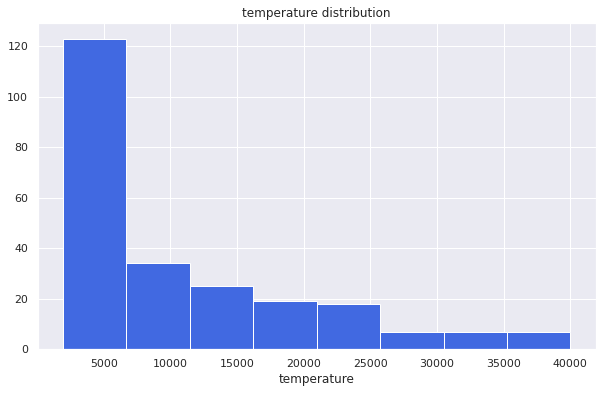

In [12]:
plt.figure(figsize=[10, 6])
data['temperature'].hist(bins=8, color='royalblue')
plt.xlabel('temperature')
plt.title('temperature distribution')

Таргет распределен экспоненциально.

Text(0.5, 1.0, 'boxplot')

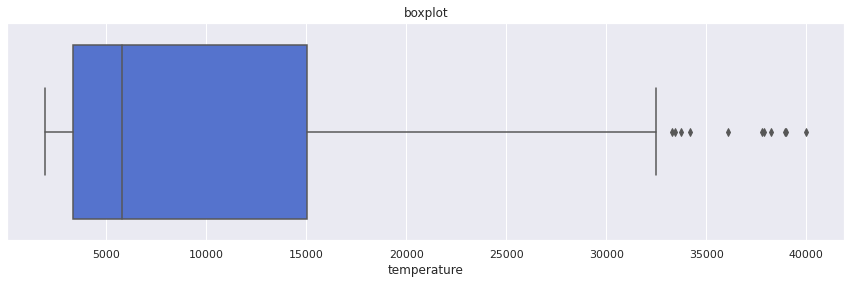

In [13]:
plt.figure(figsize=[15,4])
sns.boxplot(x=data['temperature'], color='royalblue')
plt.title('boxplot')

Изучим колонку luminosity.

Text(0.5, 1.0, 'luminosity distribution')

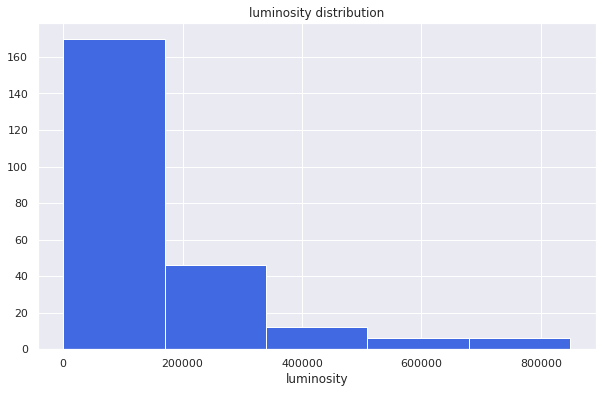

In [14]:
plt.figure(figsize=[10, 6])
data['luminosity'].hist(bins=5, color='royalblue')
plt.xlabel('luminosity')
plt.title('luminosity distribution')

Колонка luminosuty также распределена экспоненциально.

Изучим колонку radius.

Text(0.5, 1.0, 'radius distribution')

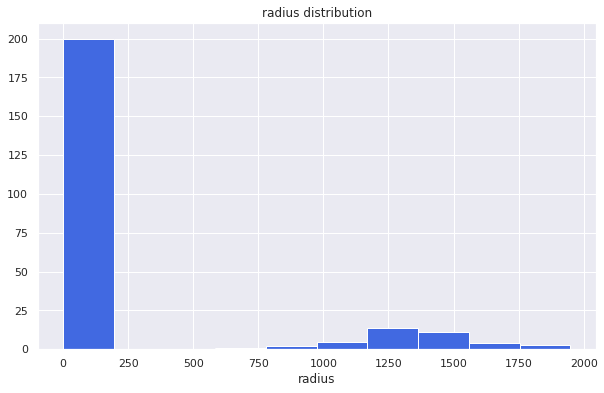

In [15]:
plt.figure(figsize=[10, 6])
data['radius'].hist(color='royalblue')
plt.xlabel('radius')
plt.title('radius distribution')

Text(0.5, 1.0, 'boxplot')

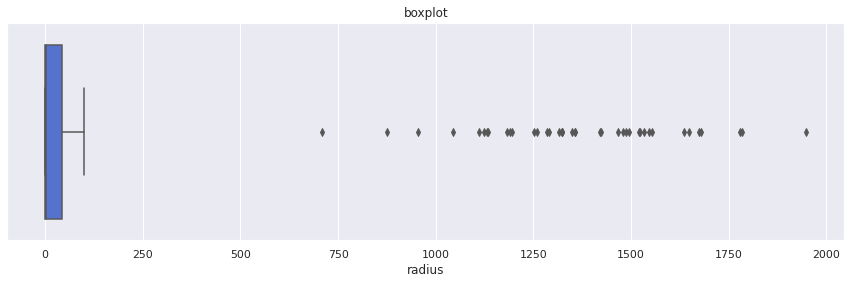

In [16]:
plt.figure(figsize=[15,4])
sns.boxplot(x=data['radius'], color='royalblue')
plt.title('boxplot')

Очень много выбросов.

Изучим колонку absolute_magnitude.

Text(0.5, 1.0, 'absolute_magnitude distribution')

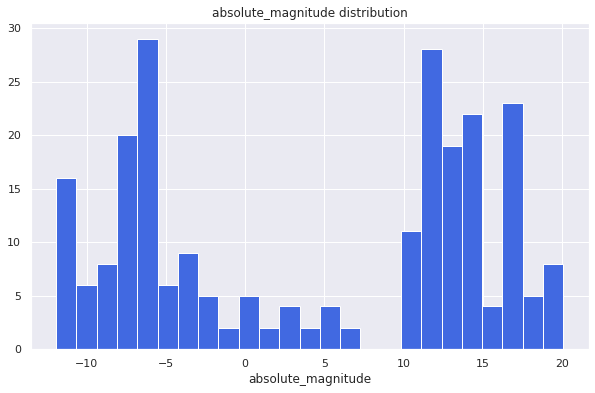

In [17]:
plt.figure(figsize=[10, 6])
data['absolute_magnitude'].hist(bins=25, color='royalblue')
plt.xlabel('absolute_magnitude')
plt.title('absolute_magnitude distribution')

Text(0.5, 1.0, 'boxplot')

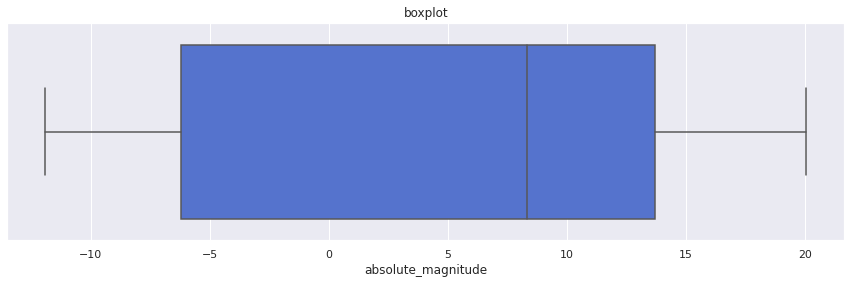

In [18]:
plt.figure(figsize=[15,4])
sns.boxplot(x=data['absolute_magnitude'], color='royalblue')
plt.title('boxplot')

Изучим колонку star_type.

In [19]:
data['star_type'].value_counts()

0    40
1    40
2    40
3    40
4    40
5    40
Name: star_type, dtype: int64

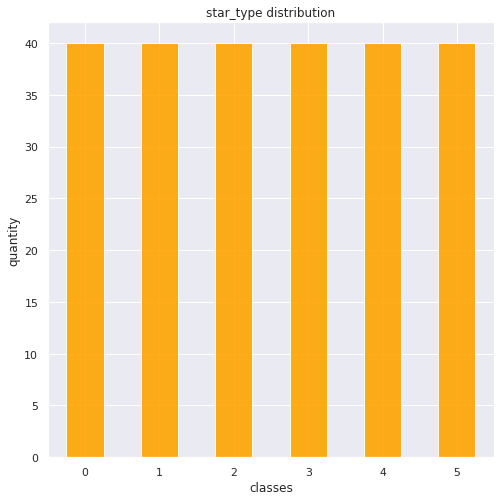

In [20]:
data['star_type'].value_counts().plot(kind='bar', title='star_type distribution', xlabel='classes', 
                                     ylabel='quantity', rot=1, color='orange', alpha =0.9, figsize=(8,8))

Изучим колонку star_color.

В колонке star_color много категорий, но много их не из-за разнообразия, а из-за того, что многие цвета одинаковы, но по-разному написаны. Исправим это.

In [21]:
data['star_color'].value_counts()

Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Blue white              3
Yellowish White         3
white                   3
Whitish                 2
Orange                  2
yellowish               2
Pale yellow orange      1
White-Yellow            1
Blue                    1
Yellowish               1
Orange-Red              1
Blue white              1
Blue-White              1
Name: star_color, dtype: int64

In [22]:
data['star_color'] = data['star_color'].str.lower()
data['star_color'] = data['star_color'].str.strip()

In [23]:
def filter(x):
    if x == 'blue white':
        return 'blue-white'
    elif x in ['yellowish white','white-yellow']:
        return 'yellow-white'
    elif x == 'whitish':
        return 'white'
    elif x == 'yellowish':
        return 'yellow'
    elif x == 'pale yellow orange':
        return 'pale yellow-orange'
    else:
        return x

In [24]:
data['star_color'] = data['star_color'].apply(filter)

In [25]:
data['star_color'].value_counts()

red                   112
blue                   56
blue-white             41
white                  12
yellow-white           12
yellow                  3
orange                  2
pale yellow-orange      1
orange-red              1
Name: star_color, dtype: int64

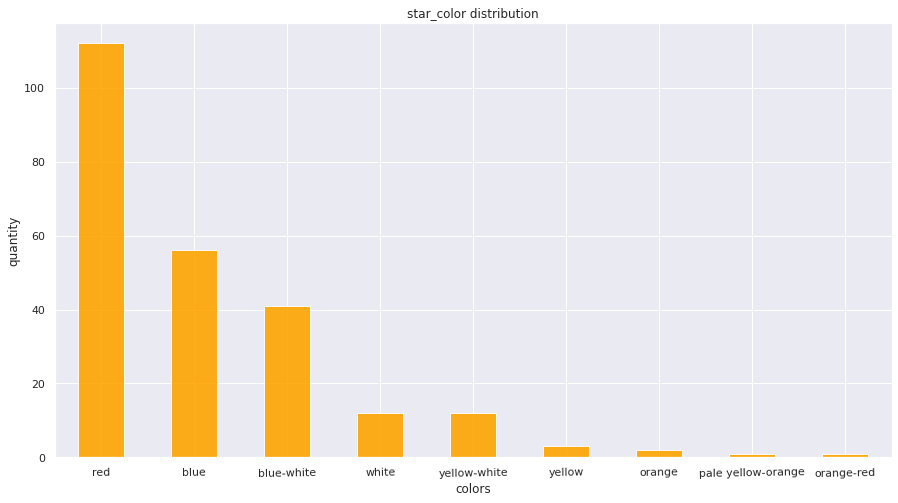

In [26]:
data['star_color'].value_counts().plot(kind='bar', title='star_color distribution', xlabel='colors', 
                                     ylabel='quantity', rot=1, color='orange', alpha =0.9, figsize=(15,8))

По графику видно, что начиная с желто-белого цвета - цвета представлены в очень маленьком количестве. Поэтому объеденим их всех в отдельную категорию - 'others'.

In [27]:
most_frequent = ['red', 'blue', 'blue-white']
data['star_color'] = data['star_color'].apply(lambda x: 'others' if x not in most_frequent else x)

Изучив количественные колонки видно, что они содержат очень много выбросов. Выбросов настолько много, что, если мы их отбросим, то наш датасет станет на 30% меньше. Наибольшая часть выбросов содержится в колонке radius. Если мы удалим все выбросы (то есть все звезды с большим радиусом) и обучим на этих данных, то при тестировании модели на звездах с большим радиусом - результаты будут плохие, поэтому не будем удалять выбросы.

# **Modeling**

Разделим данные на три части: train, validation, test.

In [28]:
x_train, x_test, y_train, y_test = train_test_split(data.drop('temperature', axis=1), data['temperature'], 
                                                    train_size=0.8, random_state=67, shuffle=True)

In [29]:
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, train_size=0.5, random_state=67, shuffle=True)

Итого у нас 80% данных в train и по 10% в validation и test.

Подготовим данные к обучению - маштабируем количественные данные и применим технику OHE к категориальным признакам.

In [30]:
x_train = pd.get_dummies(x_train, columns = ['star_type', 'star_color'], drop_first=True)
x_valid = pd.get_dummies(x_valid, columns = ['star_type', 'star_color'], drop_first=True)
x_test = pd.get_dummies(x_test, columns = ['star_type', 'star_color'], drop_first=True)

In [31]:
columns = ['luminosity', 'radius', 'absolute_magnitude']
scaler = StandardScaler()
scaler.fit(x_train[columns])
x_train[columns] = scaler.transform(x_train[columns])
x_valid[columns] = scaler.transform(x_valid[columns])
x_test[columns] = scaler.transform(x_test[columns])

Посмотрим на предобработанные данные.

Для решения данной задачи будет использовать нейросеть.

In [32]:
x_train = torch.FloatTensor(x_train.values)
x_valid = torch.FloatTensor(x_valid.values)
x_test = torch.FloatTensor(x_test.values)

In [33]:
y_train = torch.FloatTensor(y_train.values).reshape(y_train.shape[0], 1)
y_valid = torch.FloatTensor(y_valid.values).reshape(y_test.shape[0], 1)
y_test = torch.FloatTensor(y_test.values).reshape(y_test.shape[0], 1)

In [34]:
n_in_neurons, n_out_neurons = x_train.shape[1], 1 

В качестве метрики возьмем RMSE. А лосс будет MSE.

In [35]:
rmse = MeanSquaredError(squared = False)
loss = nn.MSELoss()

Для начала попробуем модель с одним скрытым слоем.

Будем обучать 1000 эпох.

In [36]:
num_epochs = 1000

Напишем функцию, чтобы не повторять один и тот же код много раз.

In [37]:
def learn_and_eval(model, num_epochs, hidden_layers=1):
  for epoch in range(num_epochs):

        optimizer.zero_grad()
      
        preds = model.forward(x_train) 
            
        loss_value = loss(preds, y_train)
        loss_value.backward()
            
        optimizer.step()
        
  model.eval()    
  res = rmse(model.forward(x_valid), y_valid)
  if hidden_layers == 1:
    print(f'h1: {n_hidden_neurons_1}, rmse: {res}')
  elif hidden_layers == 2:
    print(f'h1: {n_hidden_neurons_1}, h2: {n_hidden_neurons_2}, rmse: {res}')
  else:
    print(f'h1: {n_hidden_neurons_1}, h2: {n_hidden_neurons_2}, h3: {n_hidden_neurons_3}, rmse: {res}')

In [38]:
h1 = [100, 300, 500, 800, 1000, 1200, 1500, 1800, 2100, 2500]

In [39]:
for n_hidden_neurons_1 in h1:

    model = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_1, n_out_neurons)   
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    learn_and_eval(model, num_epochs, hidden_layers=1)

h1: 100, rmse: 16154.22265625
h1: 300, rmse: 15294.2080078125
h1: 500, rmse: 14527.779296875
h1: 800, rmse: 13518.240234375
h1: 1000, rmse: 12945.9423828125
h1: 1200, rmse: 12428.29296875
h1: 1500, rmse: 11756.751953125
h1: 1800, rmse: 11204.0283203125
h1: 2100, rmse: 10725.4765625
h1: 2500, rmse: 10256.8681640625


Лучший RMSE - 10244, при 1500 нейронах в скрытом слое.

Теперь попробуем модель с двумя скрытыми слоями.

In [40]:
h1 = list(range(300, 1500, 50))
h2 = list(range(300,1200, 50))
samples = 15 # amount of combinations

In [41]:
for i in range(samples):
    
    n_hidden_neurons_1 = h1[np.random.randint(0, len(h1))]
    n_hidden_neurons_2 = h2[np.random.randint(0, len(h2))]
    
    model = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.Tanh(),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2), 
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_2, n_out_neurons)   
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    learn_and_eval(model, num_epochs, hidden_layers=2)

h1: 450, h2: 800, rmse: 3275.176025390625
h1: 550, h2: 650, rmse: 3274.82080078125
h1: 750, h2: 450, rmse: 3261.867431640625
h1: 1400, h2: 950, rmse: 3965.99462890625
h1: 450, h2: 700, rmse: 3346.73974609375
h1: 1350, h2: 450, rmse: 3362.412841796875
h1: 1400, h2: 500, rmse: 3464.633544921875
h1: 1450, h2: 1000, rmse: 3980.4169921875
h1: 950, h2: 350, rmse: 3298.609619140625
h1: 800, h2: 650, rmse: 3302.708251953125
h1: 400, h2: 750, rmse: 3276.24609375
h1: 1350, h2: 450, rmse: 3384.77587890625
h1: 400, h2: 1000, rmse: 3290.326171875
h1: 750, h2: 500, rmse: 3237.236083984375
h1: 1250, h2: 1150, rmse: 4024.245361328125


Модель с двумя скрытыми слоями показала себя значительно лучше. Лучший RMSE уменьшился больше, чем в два раза и достиг 2246, при 450 нейронах в первом скрытом слое и 550 нейронах во втором скрытом слое.

Теперь попробуем три скрытых слоя.

In [42]:
h3 = list(range(300, 600, 50))
samples = 15 # amount of combinations

In [43]:
for i in range(samples):
    
    n_hidden_neurons_1 = h1[np.random.randint(0, len(h1))]
    n_hidden_neurons_2 = h2[np.random.randint(0, len(h2))]
    n_hidden_neurons_3 = h3[np.random.randint(0, len(h3))]
    
    model = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.Tanh(), 
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2), 
    nn.Tanh(),
    nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3),   
    nn.ReLU(), 
    nn.Linear(n_hidden_neurons_3, n_out_neurons)    
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    learn_and_eval(model, 1000, hidden_layers=3)

h1: 800, h2: 900, h3: 300, rmse: 5495.1826171875
h1: 1200, h2: 650, h3: 400, rmse: 5171.30615234375
h1: 300, h2: 950, h3: 550, rmse: 6626.69189453125
h1: 900, h2: 400, h3: 450, rmse: 5379.34423828125
h1: 1100, h2: 900, h3: 550, rmse: 5523.39892578125
h1: 1450, h2: 450, h3: 550, rmse: 5497.5068359375
h1: 350, h2: 600, h3: 350, rmse: 5730.4658203125
h1: 1250, h2: 950, h3: 450, rmse: 5448.3193359375
h1: 1300, h2: 550, h3: 300, rmse: 4951.490234375
h1: 700, h2: 550, h3: 350, rmse: 5261.69384765625
h1: 1350, h2: 400, h3: 500, rmse: 5277.345703125
h1: 700, h2: 800, h3: 500, rmse: 6346.5869140625
h1: 800, h2: 950, h3: 350, rmse: 6223.03515625
h1: 1150, h2: 700, h3: 300, rmse: 5058.54736328125
h1: 1450, h2: 350, h3: 300, rmse: 5117.28662109375


Модель с тремя скрытыми слоями показала себя лучше модели с одним скрытым слоем, но хуже, чем модель с двумя скрытыми слоями. Лучший RMSE - 2477, при 1100 нейронах в первом скрытом слое, 650 нейронах во втором скрытом слое и 450 нейронах в третьем скрытом слое.

Протестировав три различные архитектуры, в качестве основной модели возьмем двух слойную нейронную сеть с 450 нейронами в первом скрытом слое и 550 нейронами во втором скрытом слое.

In [44]:
n_hidden_neurons_1, n_hidden_neurons_2 = 750, 500 # best combination 